In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
df = pd.read_csv("..\\7. Data Preparation\\Basic_information_cleaned5.csv", index_col=0)

In [ ]:
top_50_percent = df.sort_values(by="Market Cap", ascending=False).head(int(len(df)*0.5))

In [ ]:
top_50_percent.columns

Index(['Name', 'Currency', 'Sector', 'Industry', 'Country',
       'Insider Percentage', 'Institution Percentage', 'Years since IPO',
       'NR - Percentage Missing', 'NR - Percentage Missing (Only Core)',
       'R - Percentage Missing', 'R - Percentage Missing (Only Core)',
       'R - Percentage Missing (Trivial Fix)',
       'R - Percentage Missing (Only Core) (Trivial Fix)', 'Market Cap',
       'CAGR', 'CAGR with divs', 'Years', 'Difference CAGR'],
      dtype='object')

In [ ]:
# Abrimos los datos macroeconómicos
macro_data = pd.read_csv("..\\6. Macroeconomic Data\\Macro.csv",sep=";", index_col=0)

lista_corrs = []

for index, row in top_50_percent.iterrows():
    ticker = index   

    fundamental_data = pd.read_csv("..\\7. Data Preparation\\FinalFundamentalsWithGrowth\\"+ticker+".csv", index_col=0)
    try:
        fundamental_data.drop("Forex Rate", axis=1, inplace=True)
    except:
        pass

    # Por error algunos datos tenían más columnas de las que tocaban, las ignoramos
    if fundamental_data.shape[1] > 985:
        fundamental_data = fundamental_data.iloc[:,:985]

    # Unimos los datos macroeconómicos con los fundamentales
    fundamental_data = fundamental_data.join(macro_data)


    correlaciones = fundamental_data.corr()


    lista_corrs.append(correlaciones)

In [ ]:
median_corr = np.nanmedian(lista_corrs, axis=0)

c:\Users\juani\miniconda3\envs\env3\lib\site-packages\numpy\lib\nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


In [ ]:
# mean_Corr = np.nanmean(lista_corrs, axis=0)

In [ ]:
median_df = pd.DataFrame(median_corr, index=fundamental_data.columns, columns=fundamental_data.columns)
median_df.shape

(1015, 1015)

In [ ]:
correlation_matrix = median_df.abs()

upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape),k=1).astype(np.bool))


C:\Users\juani\AppData\Local\Temp\ipykernel_496\3101505173.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape),k=1).astype(np.bool))


In [ ]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]

In [ ]:
median_corr_clean_df = median_df.drop(to_drop, axis=1)
median_corr_clean_df = median_corr_clean_df.drop(to_drop, axis=0)


In [ ]:
median_corr_clean_df.columns

Index(['Revenue', 'Gross Profit Ratio', 'Research and Development Exp.',
       'Selling, General and Administrative Exp.', 'Other Expenses',
       'Operating Expenses', 'Interest Income', 'Interest Expense (Gain)',
       'Depreciation and Amortization', 'EBITDA',
       ...
       'World Unemployment Rate',
       'Global price of Agricultural Raw Material Index',
       'CRB Commodity Index', 'All-Transactions House Price Index US',
       '30 year us fixed mortgage rates average',
       'FED Funds Rate Average Yield', 'FED Funds Rate Year Close',
       '10-Year Treasury Year Close', 'US Wage Growth', 'Real Wage Growth'],
      dtype='object', length=621)

# Feature Engineering

In [ ]:
# Quitamos columnas innecesarias
df.drop(["Name","Currency","Country","NR - Percentage Missing", "NR - Percentage Missing (Only Core)", "R - Percentage Missing (Only Core)", "R - Percentage Missing","R - Percentage Missing (Trivial Fix)", "R - Percentage Missing (Only Core) (Trivial Fix)", "Years since IPO", "Difference CAGR","CAGR with divs"], axis=1, inplace=True)

In [ ]:
ordinal = OrdinalEncoder()

df["Sector"] = ordinal.fit_transform(df["Sector"].values.reshape(-1, 1))
df["Industry"] = ordinal.fit_transform(df["Industry"].values.reshape(-1, 1))

In [ ]:
df

,Sector,Industry,Insider Percentage,Institution Percentage,Market Cap,CAGR,Years
Ticker,,,,,,,
A,6.0,33.0,0.0024,0.9126,4.528688e+10,0.065679,23.0
AA,0.0,5.0,0.0087,0.8436,7.401581e+09,0.015177,8.0
AACG,3.0,37.0,0.0553,0.1709,8.456380e+07,0.294082,14.0
AAL,7.0,3.0,0.0108,0.5432,9.895510e+09,0.171994,13.0
AAOI,9.0,119.0,0.0712,0.5119,2.069533e+08,-0.125239,8.0
...,...,...,...,...,...,...,...
ZTCOY,9.0,24.0,NaN,0.0005,1.287403e+10,0.001121,12.0
ZTO,7.0,68.0,0.0068,0.2839,2.428496e+10,0.161183,6.0
ZTS,6.0,36.0,0.0024,0.9288,9.015518e+10,0.260344,9.0


# Escogiendo fundamentales

In [ ]:
# Solo nos interesan las columans numéricas
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_df = df.select_dtypes(include=numerics)

# Quitamos otras columnas que no nos interesan
numeric_df.drop(["NR - Percentage Missing", "NR - Percentage Missing (Only Core)", "R - Percentage Missing (Only Core)", "R - Percentage Missing","R - Percentage Missing (Trivial Fix)", "R - Percentage Missing (Only Core) (Trivial Fix)"], axis=1, inplace=True)

KeyError: "['NR - Percentage Missing', 'NR - Percentage Missing (Only Core)', 'R - Percentage Missing (Only Core)', 'R - Percentage Missing', 'R - Percentage Missing (Trivial Fix)', 'R - Percentage Missing (Only Core) (Trivial Fix)'] not found in axis"

# Factores importantes a considerar usando K-means
- Número de clusters
- Semillas (Elección de centros iniciales)
- Outliers (La creación de cluster es muy sensitiva a outliers)
- Métricas de distancia
- K-means no funciona con datos categóricos (Y la conversión de estos a numéricos no es recomendable ya que carecen de "sentido de la distancia")
- El proceso puede no converger en el número dado de iteraciones; debe buscarse la convergencia.

# Construyendo el dataset

In [ ]:
aux_fundamental_data = pd.read_csv("..\\7. Data Preparation\\FinalFundamentalsWithGrowth\\FB.csv", index_col=0)
# Abrimos los datos macroeconómicos
macro_data = pd.read_csv("..\\6. Macroeconomic Data\\Macro.csv",sep=";", index_col=0)
# Unimos los datos macroeconómicos con los fundamentales
aux_fundamental_data = aux_fundamental_data.join(macro_data)

# Array vacío para guardar los resultados
res = np.empty([numeric_df.shape[0], numeric_df.shape[1] + aux_fundamental_data.shape[1]])

num = 0
for index, row in numeric_df.iterrows():
    ticker = index

    # Abrimos los fundamentales con el precio
    fundamental_data = pd.read_csv("..\\7. Data Preparation\\FinalFundamentalsWithGrowth\\"+ticker+".csv", index_col=0)

    try:
        fundamental_data.drop("Forex Rate", axis=1, inplace=True)
    except:
        pass

    # Por error algunos datos tenían más columnas de las que tocaban, las ignoramos
    if fundamental_data.shape[1] > 985:
        fundamental_data = fundamental_data.iloc[:,:985]

    # Unimos los datos macroeconómicos con los fundamentales
    fundamental_data = fundamental_data.join(macro_data)

    # Cogemos la mediana
    fundamental_data = fundamental_data.median()

    # Cogemos la fila correspondiente de numeric_df
    aux = numeric_df.loc[ticker, :]

    # Las juntamos y las guardamos en el array
    res[num, :] = aux.append(fundamental_data).to_numpy()
    num += 1

# Una vez creado el array, lo pasamos a un dataframe
res_df = pd.DataFrame(res, index=numeric_df.index,columns=numeric_df.columns.append(aux_fundamental_data.columns))

C:\Users\juani\AppData\Local\Temp\ipykernel_496\2304797539.py:36: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res[num, :] = aux.append(fundamental_data).to_numpy()
C:\Users\juani\AppData\Local\Temp\ipykernel_496\2304797539.py:36: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res[num, :] = aux.append(fundamental_data).to_numpy()
C:\Users\juani\AppData\Local\Temp\ipykernel_496\2304797539.py:36: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res[num, :] = aux.append(fundamental_data).to_numpy()
C:\Users\juani\AppData\Local\Temp\ipykernel_496\2304797539.py:36: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res[num, :] = aux.append(funda

In [ ]:
res_df.drop(to_drop, axis=1, inplace=True)

In [ ]:
res_df.replace([np.nan,np.inf, -np.inf], 0, inplace=True)

## Normalización

In [ ]:
# Normalizamos los datos
normalizer = Normalizer()
normalized_df = normalizer.fit_transform(res_df.copy())


# PCA


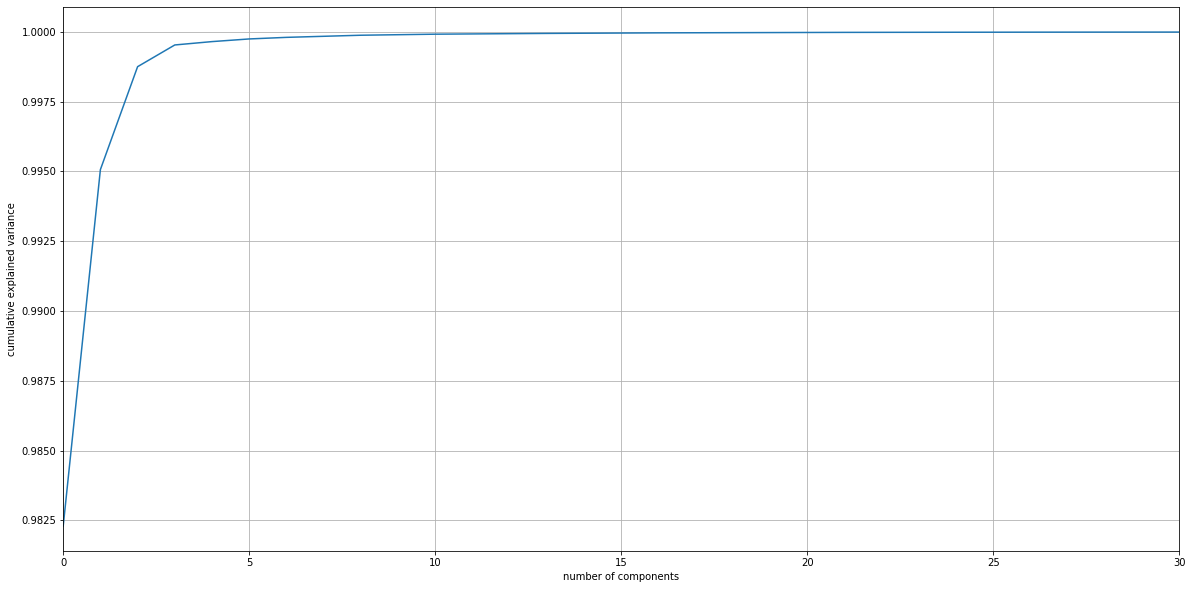

In [ ]:
plt.rcParams['figure.figsize'] = (20, 10)

pca = PCA().fit(normalized_df)

plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.grid()

plt.xlim([0, 30])
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
pca = PCA(n_components=10)
pca.fit(normalized_df)
X_pca = pca.transform(normalized_df)
print("original shape:   ", normalized_df.shape)
print("transformed shape:", X_pca.shape)

original shape:    (2683, 628)
transformed shape: (2683, 10)


In [ ]:
X_pca_df = pd.DataFrame(X_pca, index=res_df.index)
X_pca_df

,0,1,2,3,4,5,6,7,8,9
Ticker,,,,,,,,,,
A,-0.053819,0.001014,0.001916,-0.000237,-0.000060,0.000055,0.000142,0.000129,-0.000063,-1.452842e-04
AA,0.052483,-0.000326,-0.001234,0.000608,-0.000029,-0.000243,0.000034,0.000281,-0.000087,-7.897526e-05
AACG,0.002920,-0.001022,-0.001083,-0.000329,0.000032,0.000022,-0.000024,-0.000003,-0.000004,2.501989e-06
AAL,0.022797,-0.000319,-0.001454,0.002425,-0.000469,-0.000534,0.000410,-0.000149,-0.000088,4.318469e-04
AAOI,0.052487,-0.000670,-0.001214,-0.000166,0.000049,0.000014,-0.000031,0.000009,-0.000007,-3.836357e-07
...,...,...,...,...,...,...,...,...,...,...
ZTCOY,0.021696,-0.000305,-0.001461,0.000515,0.000119,0.000445,0.000212,0.000347,0.000170,1.066863e-05
ZTO,0.075498,0.000501,-0.000510,0.000046,0.000072,0.000004,-0.000094,0.000158,-0.000006,-9.375641e-05
ZTS,0.038529,0.002894,-0.001694,-0.000066,-0.000056,0.000102,0.000072,-0.000134,-0.000078,-2.608791e-06


In [1]:
aux = X_pca_df.join(res_df)
aux_corr = aux.corr()
aux_corr[X_pca_df.columns]

NameError: name 'X_pca_df' is not defined

In [ ]:
sns.heatmap(aux_corr, annot=True)

KeyboardInterrupt: 

## Eligiendo el mejor número de clusters

### Elbow method

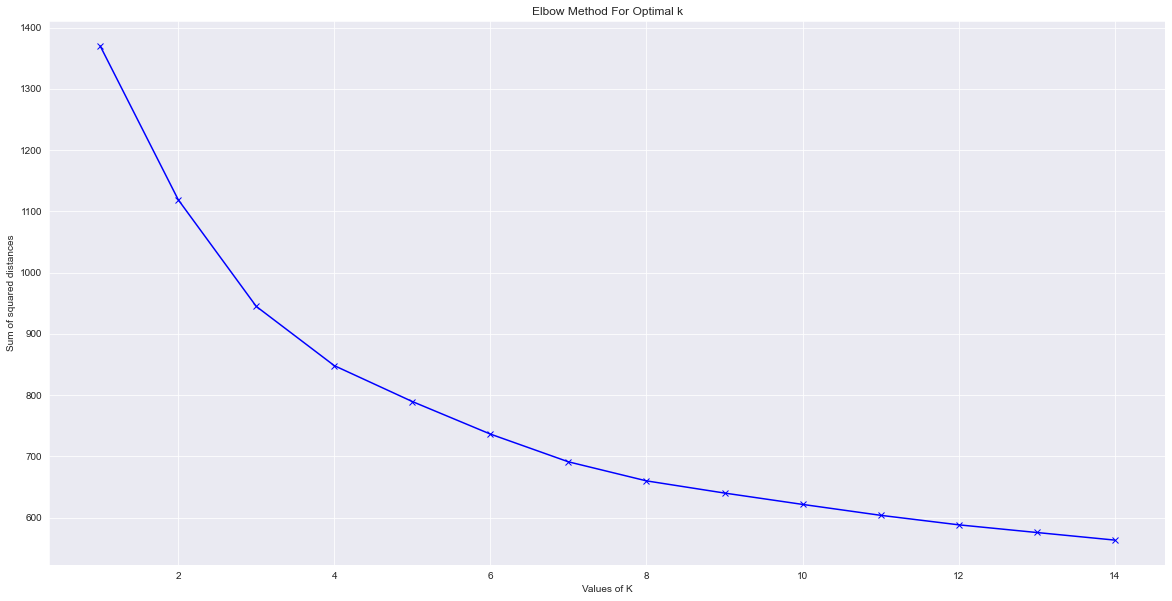

In [157]:
Sum_of_squared_distances = []
K = range(1,15)

for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters, init="k-means++")
 kmeans.fit(X_pca)
 Sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K,Sum_of_squared_distances,"bx-")
plt.xlabel("Values of K") 
plt.ylabel("Sum of squared distances") 
plt.title("Elbow Method For Optimal k")
plt.show()

### Silhouette analysis

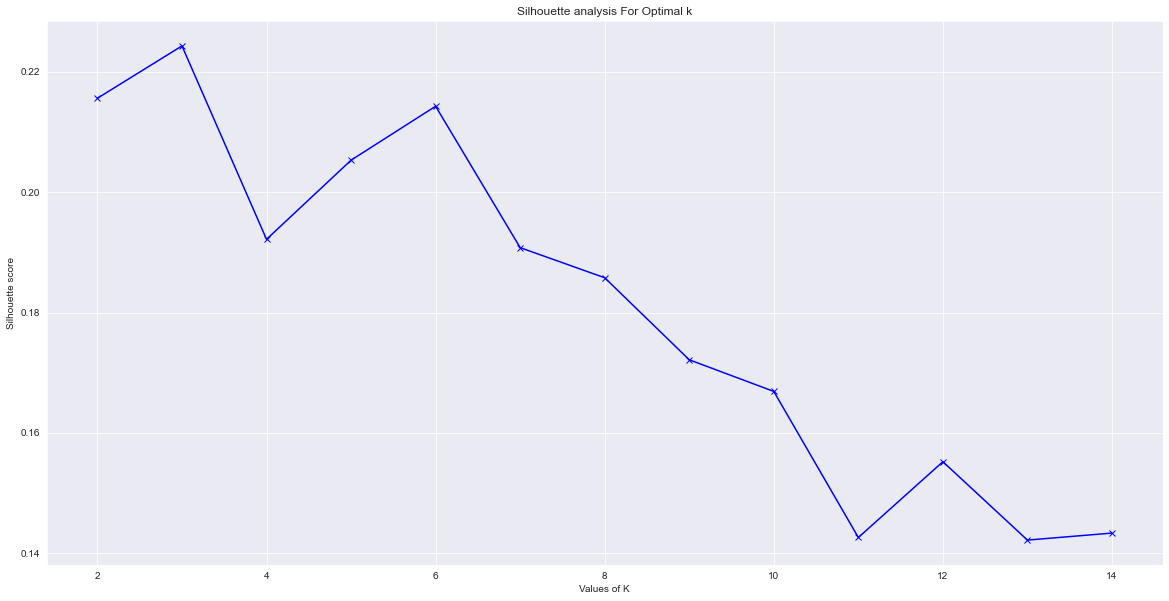

In [158]:
range_n_clusters = range(2,15)
silhouette_avg = []
for num_clusters in range_n_clusters:
 
 # initialise kmeans
 kmeans = KMeans(n_clusters=num_clusters, init="k-means++")
 kmeans.fit(X_pca)
 cluster_labels = kmeans.labels_
 
 # silhouette score
 silhouette_avg.append(silhouette_score(normalized_df, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,"bx-")
plt.xlabel("Values of K") 
plt.ylabel("Silhouette score") 
plt.title("Silhouette analysis For Optimal k")
plt.show()

## Aplicando K-means

In [159]:
# Aplicamos K means usando K = 5 dado por el silouhette y el elbow
kmeans = KMeans(n_clusters=6, init="k-means++").fit(X_pca)
labels = kmeans.labels_

res_df["Cluster"] = labels
df['Cluster'] = labels

### Resultados

In [160]:
df["Cluster"].value_counts()

3    869
2    768
1    647
4    321
0    298
5     94
Name: Cluster, dtype: int64

In [44]:
pd.options.display.max_columns = 500
res_df[res_df["Cluster"] == 2].describe()

,Insider Percentage,Institution Percentage,Years since IPO,R - Percentage Missing (Trivial Fix),Market Cap,CAGR,CAGR with divs,Years,Revenue,COGS,Gross Profit,Gross Profit Ratio,Research and Development Exp.,"Selling, General and Administrative Exp.",Other Expenses,Operating Expenses,COGS and Expenses,Interest Income,Interest Expense (Gain),Depreciation and Amortization,EBITDA,EBITDA ratio,Operating Income,Operating Income ratio,Total Other Income Expenses (Gains),Income Before Tax,Income Before Tax Ratio,Income Tax expense (Gain),Net Income,Net Income ratio,EPS,EPS Diluted,Weighted Average Shares Outstanding,Weighted Average Shares Outstanding Diluted,Cash and Cash Equivalents,Short-Term Investments,Cash and Short-Term Investments,Net Receivables,Inventory,Other Current Assets,Total Current Assets,PP&E,Goodwill,Intangible Assets,Investments,Tax Assets,Other Non-Current Assets,Total Non-Current Assets,Other Assets,Total Assets,Accounts Payable,Short-Term Debt,Tax Payable,Deferred Revenue,Other Current Liabilities,Total Current Liabilities,Long-Term Debt,Deferred Tax Liabilities,Other Non-Current Liabilities,Total Non-Current Liabilities,Other Liabilities,Capital Lease Obligations,Total Liabilities,Preferred Stock,Common Stock,Retained Earnings,Other Comprehensive Income/Loss,Other Total Stockholders Equity,Total Stockholders Equity,Total Liabilities And Stockholders Equity,Minority Interest,Total Liabilities & Equity,Deferred Income Tax,Stock Based Compensation,Change in Working Capital,Accounts Receivable,Other Working Capital,Other Non-Cash Items,Cash Provided by Operating Activities,CAPEX,Acquisitions Net,Purchases of Investments,Sales/Maturities of Investments,Other Investing Activites,Cash Used for Investing Activites,Debt Repayment,Common Stock Issued,Common Stock Repurchased,Dividends Paid,Other Financing Activites,Cash Used/Provided by Financing Activities,Effect of Forex Changes on Cash,Net Change In Cash,Cash at the End of Period,Cash at the Beginning of Period,Free Cash Flow,Open,High,Low,Close,Adj Close,Volume,Dividend,Dividend Cum,Close with cum Dividends,Adj. Close with cum Dividends,FCF Ratio,FCF per share,CAPEX per share,Book value,Book value per share,Total Debt,Financial leverage,Cash to Debt Ratio,Cash and Long Term Investments,Cash and Long Term Investements to Debt Ratio,Net Debt,Net Debt minus Investments,Working Capital,Current Ratio,Quick Ratio,Debt to Equity,Debt to Assets,Interest Coverage,Return on Equity,Return on Assets,Tax Rate,NOPAT,Invested Capital,Return on Invested Capital,Plowback Ratio,Dividend & Repurchase / FCF,Dividend & Repurchase / EBITDA,Cluster
count,170.000000,170.000000,170.000000,170.000000,1.700000e+02,170.000000,170.000000,170.000000,1.700000e+02,1.700000e+02,1.700000e+02,170.000000,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,170.000000,1.700000e+02,170.000000,1.700000e+02,1.700000e+02,170.000000,1.700000e+02,1.700000e+02,170.000000,170.000000,170.000000,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,170.000000,170.000000,170.000000,170.000000,170.000000,1.700000e+02,170.00000,170.000000,170.000000,170.000000,1.700000e+02,1.700000e+02,170

In [161]:
df[df["Cluster"] == 5]

,Name,Sector,Industry,Insider Percentage,Institution Percentage,Years since IPO,NR - Percentage Missing,NR - Percentage Missing (Only Core),R - Percentage Missing,R - Percentage Missing (Only Core),R - Percentage Missing (Trivial Fix),R - Percentage Missing (Only Core) (Trivial Fix),Market Cap,CAGR,CAGR with divs,Years,Madurez,Tamaño,Rentabilidad,Rentabilidad with divs,Insider Ownership,Institutional Ownership,Cluster
Ticker,,,,,,,,,,,,,,,,,,,,,,,
AAU,ALMADEN MINERALS LTD.,Basic Materials,Gold,0.0407,0.0563,32.0,0.306000,0.150000,0.238776,0.0,0.028571,0.0,6.097739e+07,0.083278,0.083278,5.0,Maduro,Pequeña,Normal,Normal,Media,Baja,5
ABMC,AMERICAN BIO MEDICA CORPORATION,Healthcare,Diagnostics & Research,0.3054,NaN,16.0,0.266522,0.076087,0.193878,0.0,0.022321,0.0,5.939330e+06,-0.108612,-0.108612,16.0,Maduro,Pequeña,Muy Mala,Muy Mala,Alta,NaN,5
ABQQ,AB INTERNATIONAL GROUP CORP.,Technology,Software—Application,0.0439,NaN,6.0,0.311667,0.104167,0.250000,0.0,0.020408,0.0,1.361999e+07,-0.897126,-0.897126,2.0,Medio,Pequeña,Muy Mala,Muy Mala,Media,NaN,5
ADMT,"ADM TRONICS UNLIMITED, INC.",Healthcare,Medical Devices,0.4449,NaN,32.0,0.325000,0.085938,0.231293,0.0,0.037415,0.0,8.786504e+06,-0.050018,-0.050018,12.0,Maduro,Pequeña,Mala,Mala,Alta,NaN,5
AGE,"AGEX THERAPEUTICS, INC.",Healthcare,Biotechnology,0.4347,0.1793,4.0,0.256667,0.041667,0.209184,0.0,0.025510,0.0,4.131326e+07,-0.618467,-0.618467,2.0,Medio,Pequeña,Muy Mala,Muy Mala,Alta,Baja,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VEV,VICINITY MOTOR CORP.,Consumer Cyclical,Auto Manufacturers,0.1146,0.0098,2.0,0.254000,0.075000,0.193878,0.0,0.020408,0.0,2.430374e+07,-0.148850,-0.148850,2.0,Jóven,Pequeña,Muy Mala,Muy Mala,Media,Baja,5
WECT,WECONNECT TECH INTERNATIONAL INC.,Technology,Shell Companies,NaN,NaN,2.0,0.445000,0.294643,0.219388,0.0,0.020408,0.0,2.442705e+07,3.610656,3.610656,2.0,Jóven,Pequeña,Muy Buena,Muy Buena,NaN,NaN,5
WVE,WAVE LIFE SCIENCES LTD.,Healthcare,Biotechnology,0.0707,0.8123,7.0,0.241429,0.053571,0.165816,0.0,0.020408,0.0,2.981741e+08,0.418242,0.418242,4.0,Medio,Pequeña,Muy Buena,Muy Buena,Media,Media,5


In [48]:
df[df["Cluster"] == 2].describe()

,Insider Percentage,Institution Percentage,Years since IPO,NR - Percentage Missing,NR - Percentage Missing (Only Core),R - Percentage Missing,R - Percentage Missing (Only Core),R - Percentage Missing (Trivial Fix),R - Percentage Missing (Only Core) (Trivial Fix),Market Cap,CAGR,CAGR with divs,Years,Cluster
count,152.000000,164.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.0,1.700000e+02,169.000000,169.000000,170.000000,170.0
mean,0.125525,0.558583,19.917647,0.274206,0.139887,0.181919,0.023529,0.027117,0.0,9.590330e+09,0.246696,0.213353,6.682353,2.0
std,0.183431,0.287088,16.662832,0.070806,0.117996,0.136925,0.152025,0.024407,0.0,2.525249e+10,0.316895,0.234865,6.409519,0.0
min,0.000500,0.000000,2.000000,0.121000,0.000000,0.073469,0.000000,0.000000,0.0,2.432786e+05,-0.312401,-0.284069,2.000000,2.0
25%,0.013275,0.328250,8.250000,0.230326,0.019075,0.124980,0.000000,0.005904,0.0,4.369130e+08,0.048757,0.072684,2.000000,2.0
50%,0.059400,0.626950,17.000000,0.274580,0.145623,0.156103,0.000000,0.020801,0.0,1.719961e+09,0.123693,0.146720,3.000000,2.0
75%,0.141700,0.798800,28.000000,0.315592,0.230769,0.193878,0.000000,0.040816,0.0,5.289808e+09,0.447048,0.300765,9.000000,2.0
max,0.968200,0.996600,152.000000,0.621429,0.657143,1.000000,1.000000,0.102041,0.0,1.608644e+11,1.286778,1.116591,37.000000,2.0


In [162]:
df[df["Cluster"] == 5]["Sector"].value_counts()

Healthcare                24
Technology                17
Industrials               12
Communication Services    10
Consumer Cyclical          9
Basic Materials            6
Consumer Defensive         6
Financial Services         5
Energy                     4
Real Estate                1
Name: Sector, dtype: int64

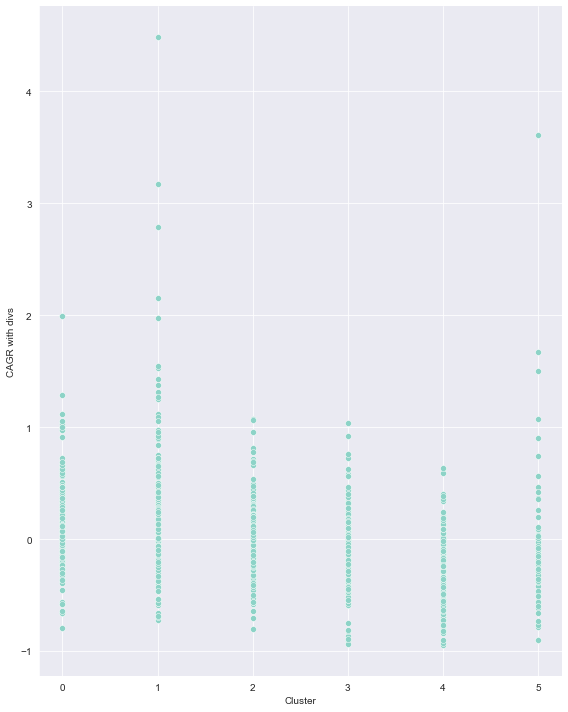

In [163]:
sns.relplot(data=df, x="Cluster", y="CAGR with divs", height=10, aspect=12/15)

<AxesSubplot:xlabel='CAGR with divs', ylabel='Count'>

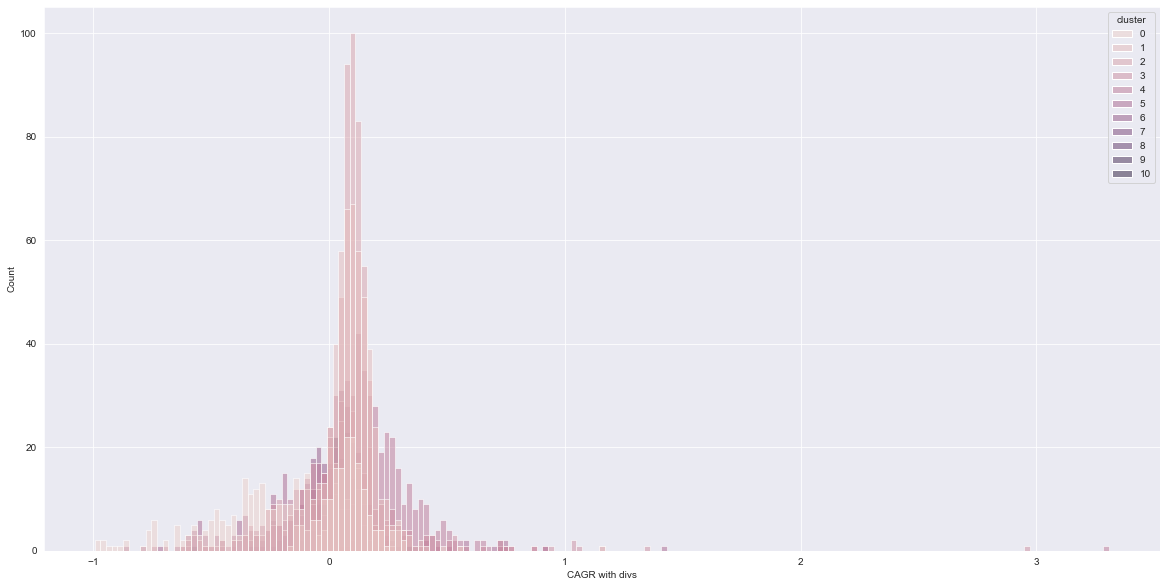

In [315]:
sns.histplot(data=df, x="CAGR with divs", hue="cluster")